In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ue21cs342aa2/sample_submission.csv
/kaggle/input/ue21cs342aa2/train.csv
/kaggle/input/ue21cs342aa2/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [3]:
train = pd.read_csv("train.csv", index_col = 0)
test = pd.read_csv("test.csv", index_col = 0)

In [4]:
train.head()

,Date,Open,Close,Volume,Strategy
id,,,,,
0,2015-06-01,66.208486,75.609978,298506300,Hold
1,2015-06-08,64.116235,74.443331,227974800,Hold
2,2015-06-15,47.701942,71.140831,250670900,Buy
3,2015-06-22,54.754816,72.881344,223614300,Hold
4,2015-06-29,48.031899,66.284718,406814900,Buy


In [5]:
print(train.shape)
train.dtypes

(300, 5)


Date         object
Open        float64
Close       float64
Volume        int64
Strategy     object
dtype: object

In [6]:
train.isnull().sum()

Date        0
Open        0
Close       0
Volume      0
Strategy    0
dtype: int64

In [7]:
train.duplicated().sum()

0

In [8]:
train.sort_values('Date', inplace=True)
train['Date'] = pd.to_datetime(train['Date'])
train.set_index('Date', inplace=True)
train.head()

,Open,Close,Volume,Strategy
Date,,,,
2015-06-01,66.208486,75.609978,298506300,Hold
2015-06-08,64.116235,74.443331,227974800,Hold
2015-06-15,47.701942,71.140831,250670900,Buy
2015-06-22,54.754816,72.881344,223614300,Hold
2015-06-29,48.031899,66.284718,406814900,Buy


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


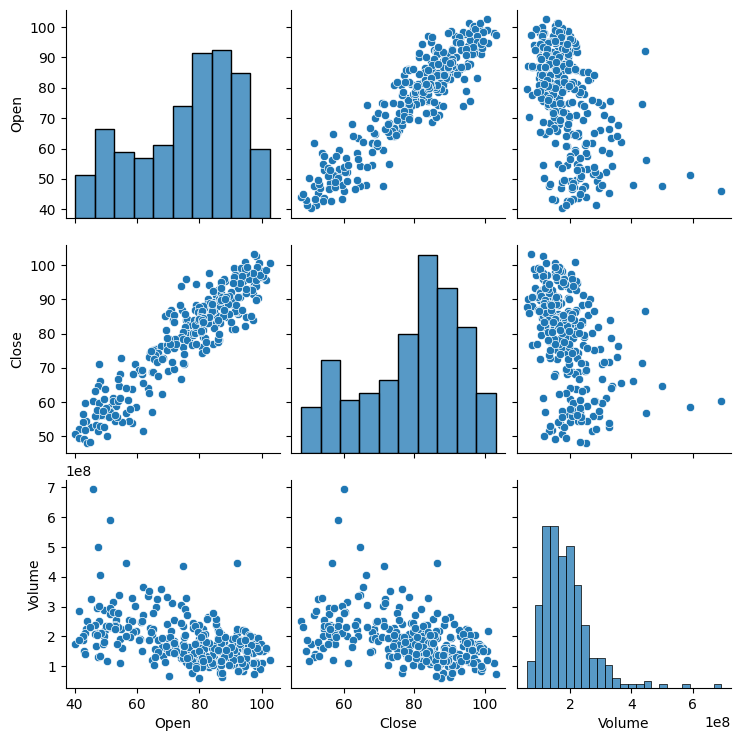

In [9]:
import seaborn as sns
sns.pairplot(train)

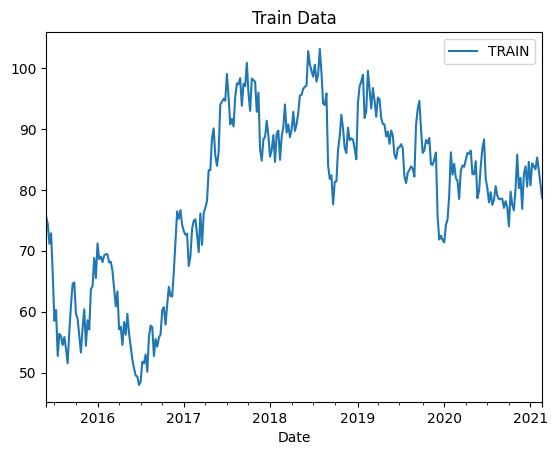

In [10]:
train['Close'].plot(legend=True,label='TRAIN')
plt.title('Train Data');

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Calculate RSI manually
def calculate_rsi(data, window):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

In [12]:
def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    """Compute the MACD (Moving Average Convergence/Divergence)."""
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = short_ema - long_ema
    data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    data['MACD_Histogram'] = data['MACD'] - data['Signal_Line']

    return data


In [13]:
train_data = pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv")

# Convert 'Date' column to datetime
train_data['Date'] = pd.to_datetime(train_data['Date'])

# Set alpha (smoothing factor)
alpha = 0.2


In [14]:
# Load the test data
test_data = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv")

# Convert 'Date' column to datetime
test_data['Date'] = pd.to_datetime(test_data['Date'])



In [15]:
# ARIMA predictions for 'Close' in test data
alpha = 0.2
forecast = train_data["Close"].iloc[-1]
predicted_closes = []

for i in range(len(test_data)):
    close_value = alpha * test_data["Open"].iloc[i] + (1 - alpha) * forecast
    forecast = close_value

    arima_model = ARIMA(train_data["Close"], order=(4, 1, 2))
    arima_results = arima_model.fit()
    arima_forecast = arima_results.forecast(steps=1)
    arima_close = arima_forecast.iat[0]

    if np.abs(arima_close - close_value) < 1.0:
        predicted_close = arima_close
    else:
        predicted_close = close_value

    predicted_closes.append(predicted_close)

test_data["Close"] = predicted_closes

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.10/site-packages/statsmodels

In [16]:
# Compute MACD related features for train data
train_data = compute_macd(train_data)

# Compute MACD related features for test data
test_data = compute_macd(test_data)

train_data['MA'] = train_data['Close'].rolling(window=10).mean()
train_data['RSI'] = calculate_rsi(train_data['Close'], 14)
test_data['MA'] = test_data['Close'].rolling(window=10).mean()
test_data['RSI'] = calculate_rsi(test_data['Close'], 14)

label_encoder = LabelEncoder()
train_data["Strategy_Label"] = label_encoder.fit_transform(train_data["Strategy"])

X_train = train_data[["Open", "Close", "Volume", "MA", "RSI", "MACD", "Signal_Line", "MACD_Histogram"]]
X_test = test_data[["Open", "Close", "Volume", "MA", "RSI", "MACD", "Signal_Line", "MACD_Histogram"]]
y_train = train_data["Strategy_Label"]

In [17]:
# Split the training data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Hyperparameter tuning
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
}

model = xgb.XGBClassifier(random_state=42)
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

best_model.fit(X_train, y_train)
accuracy = best_model.score(X_val, y_val)

predicted_strategy = best_model.predict(X_test)
predicted_strategy = label_encoder.inverse_transform(predicted_strategy)
test_data["Strategy"] = predicted_strategy



In [18]:
#Save the DataFrame to a CSV file named "submission.csv"
submission_df = test_data[['id', "Date", "Close", "Strategy"]]
submission_df.to_csv("submission.csv", index=False)